In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.33
#session = InteractiveSession(config = config)

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install np_utils

     |████████████████████████████████| 61kB 8.4MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57126 sha256=f4ee3b40c009fe8a237c4d538446c6e860911d347fedbf695e01adca7864eaf3
  Stored in directory: /root/.cache/pip/wheels/92/4b/81/206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import os 
from keras.preprocessing.image import * 
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix

from PIL import Image




In [5]:
import zipfile

img = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/tree (1).zip')
img.extractall('img2')

img.close()

In [6]:
import zipfile

img = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/test_img.zip')
img.extractall('test2')

img.close()

In [7]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tree_label_final.csv')

In [8]:
df

version shapes  imagePath  ... flags.knot  flags.willow  flags.keyhole
0      4.5.7     []  10284.png  ...          0             0              0
1      4.5.7     []  10208.png  ...          0             0              0
2      4.5.7     []  10217.png  ...          0             0              0
3      4.5.7     []  10238.png  ...          0             0              0
4      4.5.7     []  10257.png  ...          0             0              0
...      ...    ...        ...  ...        ...           ...            ...
9924   4.5.7     []   5741.png  ...          1             0              0
9925   4.5.7     []    593.png  ...          1             0              0
9926   4.5.7     []   6426.png  ...          1             0              0
9927   4.5.7     []   4167.png  ...          1             0              0
9928   4.5.7     []   3910.png  ...          1             0              0

[9929 rows x 13 columns]

In [9]:
def white_to_black(img_path):
  img = Image.open(img_path)
  for i in range(img.size[0]):  #x방향 탐색
    for j in range(img.size[1]):  #y방향 탐색
        rgb = img.getpixel((i,j))
        rgb_img = (255-rgb[0], 255-rgb[1], 255-rgb[2])
        img.putpixel((i,j), rgb_img)
  return img



In [10]:
data = pd.DataFrame(df, columns=['imagePath','flags.root',	'flags.branch',	'flags.fruit',	'flags.leaves',	'flags.knot','flags.willow','flags.keyhole'])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9929 entries, 0 to 9928
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   imagePath      9929 non-null   object
 1   flags.root     9929 non-null   int64 
 2   flags.branch   9929 non-null   int64 
 3   flags.fruit    9929 non-null   int64 
 4   flags.leaves   9929 non-null   int64 
 5   flags.knot     9929 non-null   int64 
 6   flags.willow   9929 non-null   int64 
 7   flags.keyhole  9929 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 620.7+ KB


In [13]:
for i in data['imagePath']:
    white_to_black('img2/'+i)

In [14]:
columns=['flags.root',	'flags.branch',	'flags.fruit',	'flags.leaves',	'flags.knot','flags.willow','flags.keyhole']
for i in range(7):
    print(df[columns[i]].value_counts())


0    7933
1    1996
Name: flags.root, dtype: int64
0    7257
1    2672
Name: flags.branch, dtype: int64
0    9785
1     144
Name: flags.fruit, dtype: int64
1    9607
0     322
Name: flags.leaves, dtype: int64
0    9362
1     567
Name: flags.knot, dtype: int64
0    9908
1      21
Name: flags.willow, dtype: int64
0    9750
1     179
Name: flags.keyhole, dtype: int64


In [15]:
train_df, data_df = train_test_split(data , test_size=0.2, random_state= 2045)

train_df=train_df.reset_index(drop=True)
data_df=data_df.reset_index(drop=True)

In [16]:
test_df, valid_df = train_test_split(data_df , test_size=0.2, random_state= 2045)

test_df=test_df.reset_index(drop=True)
valid_df=valid_df.reset_index(drop=True)

In [17]:
total_train=train_df.shape[0]
total_validate=valid_df.shape[0]
batch_size=32
path = 'img2/'
IMAGE_SIZE = (256,256)
columns=['flags.root',	'flags.branch',	'flags.fruit',	'flags.leaves',	'flags.knot','flags.willow','flags.keyhole']


# 트레이닝 데이터의 제너레이터 설정 
#train_datagen=ImageDataGenerator(rotation_range=15,rescale=1./255,shear_range=0.1, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.1,height_shift_range=0.1)

train_datagen=ImageDataGenerator(rescale=1./255)



train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path,
    x_col = "imagePath", 
    y_col = columns,
    target_size = IMAGE_SIZE,
    class_mode = "raw",
    batch_size = batch_size )
    
validate_datagen=ImageDataGenerator(rescale=1./255)

validation_generator=validate_datagen.flow_from_dataframe(
    valid_df,
    path,
    x_col= "imagePath",
    y_col= columns,
    target_size = IMAGE_SIZE,
    class_mode = "raw",
    batch_size = batch_size )

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path,
    x_col= "imagePath",
    y_col= columns,
    target_size = IMAGE_SIZE,
    class_mode = "raw",
    batch_size = batch_size )





Found 7943 validated image filenames.
Found 398 validated image filenames.
Found 1588 validated image filenames.


In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(256, 256, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))





model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

callbacks = [es,mc]

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

In [21]:
epochs = 200

history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data=  validation_generator,
    callbacks = callbacks)


Epoch 1/200
249/249 [==============================] - 71s 109ms/step - loss: 0.4601 - acc: 0.6172 - val_loss: 0.2993 - val_acc: 0.6859

Epoch 00001: val_acc improved from -inf to 0.68593, saving model to model2.h5
Epoch 2/200
249/249 [==============================] - 26s 104ms/step - loss: 0.2513 - acc: 0.6565 - val_loss: 0.2511 - val_acc: 0.6859

Epoch 00002: val_acc did not improve from 0.68593
Epoch 3/200
249/249 [==============================] - 26s 104ms/step - loss: 0.2339 - acc: 0.6651 - val_loss: 0.2305 - val_acc: 0.6859

Epoch 00003: val_acc did not improve from 0.68593
Epoch 4/200
249/249 [==============================] - 26s 102ms/step - loss: 0.2340 - acc: 0.6625 - val_loss: 0.2346 - val_acc: 0.6859

Epoch 00004: val_acc did not improve from 0.68593
Epoch 5/200
249/249 [==============================] - 26s 103ms/step - loss: 0.2323 - acc: 0.6606 - val_loss: 0.2202 - val_acc: 0.6859

Epoch 00005: val_acc did not improve from 0.68593
Epoch 6/200
249/249 [================

In [28]:
test = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/test_data2.xlsx')

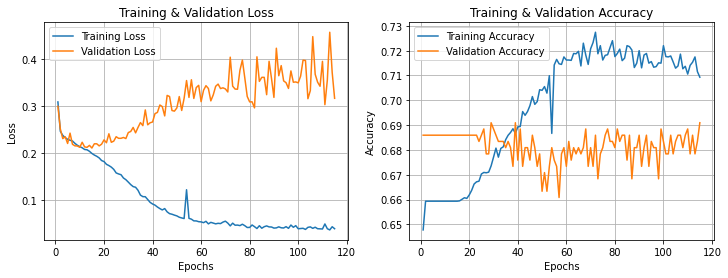

In [29]:
import matplotlib.pyplot as plt 

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

In [30]:
loaded_model = load_model('model2.h5')

loss, accuracy = loaded_model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 4s 84ms/step - loss: 0.2552 - acc: 0.6568
Loss = 0.25519
Accuracy = 0.65680


In [31]:


y_pred = loaded_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

y_true = test_generator.labels.astype(int)


print(columns)
multilabel_confusion_matrix(y_true, y_pred)

['flags.root', 'flags.branch', 'flags.fruit', 'flags.leaves', 'flags.knot', 'flags.willow', 'flags.keyhole']


array([[[1206,   49],
        [ 316,   17]],

       [[1070,   94],
        [ 388,   36]],

       [[1564,    0],
        [  24,    0]],

       [[   0,   54],
        [  15, 1519]],

       [[1474,   17],
        [  95,    2]],

       [[1586,    0],
        [   2,    0]],

       [[1538,   20],
        [  30,    0]]])

In [32]:
from sklearn import metrics

print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.05      0.09       333
           1       0.28      0.08      0.13       424
           2       0.00      0.00      0.00        24
           3       0.97      0.99      0.98      1534
           4       0.11      0.02      0.03        97
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        30

   micro avg       0.87      0.64      0.74      2444
   macro avg       0.23      0.16      0.18      2444
weighted avg       0.69      0.64      0.65      2444
 samples avg       0.91      0.77      0.79      2444



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
